# Bank Churn Prediction Project
## Tarun Tanwar

In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from imblearn.over_sampling import SMOTE

import joblib
import warnings
warnings.filterwarnings('ignore')


## Load and Clean Data

In [2]:
# Load Excel file
xls = pd.ExcelFile("Bank_Churn_Messy.xlsx")
customer_df = xls.parse('Customer_Info')
account_df = xls.parse('Account_Info')

In [3]:
# Clean columns
customer_df['EstimatedSalary'] = customer_df['EstimatedSalary'].replace('[€,]', '', regex=True).astype(float)
account_df['Balance'] = account_df['Balance'].replace('[€,]', '', regex=True).astype(float)
account_df['HasCrCard'] = account_df['HasCrCard'].map({'Yes': 1, 'No': 0})
account_df['IsActiveMember'] = account_df['IsActiveMember'].map({'Yes': 1, 'No': 0})
customer_df['Geography'] = customer_df['Geography'].replace({'FRA': 'France', 'French': 'France'})

In [4]:
# Merge datasets
df = pd.merge(customer_df, account_df, on=['CustomerId', 'Tenure'])
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,EstimatedSalary,Balance,NumOfProducts,HasCrCard,IsActiveMember,Exited
0,15634602,Hargrave,619,France,Female,42.0,2,101348.88,0.00,1,1,1,1
1,15634602,Hargrave,619,France,Female,42.0,2,101348.88,0.00,1,1,1,1
2,15647311,Hill,608,Spain,Female,41.0,1,112542.58,83807.86,1,1,1,0
3,15619304,Onio,502,France,Female,42.0,8,113931.57,159660.80,3,0,0,1
4,15701354,Boni,699,France,Female,39.0,1,93826.63,0.00,2,0,0,0


## Exploratory Data Analysis

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10004 entries, 0 to 10003
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10004 non-null  int64  
 1   Surname          10001 non-null  object 
 2   CreditScore      10004 non-null  int64  
 3   Geography        10004 non-null  object 
 4   Gender           10004 non-null  object 
 5   Age              10001 non-null  float64
 6   Tenure           10004 non-null  int64  
 7   EstimatedSalary  10004 non-null  float64
 8   Balance          10004 non-null  float64
 9   NumOfProducts    10004 non-null  int64  
 10  HasCrCard        10004 non-null  int64  
 11  IsActiveMember   10004 non-null  int64  
 12  Exited           10004 non-null  int64  
dtypes: float64(3), int64(7), object(3)
memory usage: 1.1+ MB


In [6]:
df.describe()

,CustomerId,CreditScore,Age,Tenure,EstimatedSalary,Balance,NumOfProducts,HasCrCard,IsActiveMember,Exited
count,1.000400e+04,10004.000000,10001.000000,10004.000000,10004.000000,10004.000000,10004.000000,10004.000000,10004.000000,10004.000000
mean,1.569092e+07,650.568073,38.919108,5.012195,99743.889855,76494.334391,1.529988,0.514994,0.514994,0.203719
std,7.193218e+04,96.665531,10.488725,2.891806,60581.133136,62396.534285,0.581635,0.499800,0.499800,0.402782
min,1.556570e+07,350.000000,18.000000,0.000000,-999999.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,1.562839e+07,584.000000,32.000000,3.000000,50904.965000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,1.569071e+07,652.000000,37.000000,5.000000,100168.240000,97221.520000,1.000000,1.000000,1.000000,0.000000
75%,1.575322e+07,718.000000,44.000000,7.000000,149382.097500,127656.530000,2.000000,1.000000,1.000000,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,199992.480000,250898.090000,4.000000,1.000000,1.000000,1.000000


In [7]:
# Check Duplicates
df.duplicated()

0        False
1         True
2        False
3        False
4        False
         ...  
9999     False
10000    False
10001     True
10002     True
10003     True
Length: 10004, dtype: bool

In [8]:
df.duplicated().sum()

4

In [9]:
# Drop Duplicates
df.drop_duplicates(subset=['CustomerId'],inplace=True)

In [10]:
df.duplicated().sum()

0

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          9997 non-null   object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              9997 non-null   float64
 6   Tenure           10000 non-null  int64  
 7   EstimatedSalary  10000 non-null  float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  Exited           10000 non-null  int64  
dtypes: float64(3), int64(7), object(3)
memory usage: 1.1+ MB


In [12]:
df.describe()

,CustomerId,CreditScore,Age,Tenure,EstimatedSalary,Balance,NumOfProducts,HasCrCard,IsActiveMember,Exited
count,1.000000e+04,10000.000000,9997.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.922077,5.012800,99762.195289,76485.889288,1.530200,0.515100,0.515100,0.203700
std,7.193619e+04,96.653299,10.489072,2.892174,60583.863580,62397.405202,0.581654,0.499797,0.499797,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,-999999.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,50910.677500,0.000000,1.000000,0.000000,0.000000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,100191.725000,97198.540000,1.000000,1.000000,1.000000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,149388.247500,127644.240000,2.000000,1.000000,1.000000,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,199992.480000,250898.090000,4.000000,1.000000,1.000000,1.000000


In [13]:
df[df['EstimatedSalary'] <= 0]

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,EstimatedSalary,Balance,NumOfProducts,HasCrCard,IsActiveMember,Exited
29,15728693,NaN,574,Germany,Female,NaN,3,-999999.0,141349.43,1,1,1,0
122,15580203,NaN,674,Spain,Male,NaN,6,-999999.0,120193.42,1,0,0,0
9390,15756954,NaN,538,France,Female,NaN,2,-999999.0,0.00,1,1,1,0


In [14]:
df.isnull().sum()

CustomerId         0
Surname            3
CreditScore        0
Geography          0
Gender             0
Age                3
Tenure             0
EstimatedSalary    0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
Exited             0
dtype: int64

In [15]:
df = df[df['EstimatedSalary'] >= 0]

In [16]:
df.describe()

,CustomerId,CreditScore,Age,Tenure,EstimatedSalary,Balance,NumOfProducts,HasCrCard,IsActiveMember,Exited
count,9.997000e+03,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000
mean,1.569094e+07,650.545364,38.922077,5.013204,100092.222656,76482.679807,1.530359,0.515055,0.515055,0.203761
std,7.193443e+04,96.657932,10.489072,2.892364,57518.775702,62397.174721,0.581669,0.499798,0.499798,0.402814
min,1.556570e+07,350.000000,18.000000,0.000000,11.580000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,50974.570000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,1.569073e+07,652.000000,37.000000,5.000000,100236.020000,97188.620000,1.000000,1.000000,1.000000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,149399.700000,127642.440000,2.000000,1.000000,1.000000,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,199992.480000,250898.090000,4.000000,1.000000,1.000000,1.000000


In [17]:
df[df['EstimatedSalary'] <= 0]

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,EstimatedSalary,Balance,NumOfProducts,HasCrCard,IsActiveMember,Exited


In [18]:
df.isnull().sum()

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
EstimatedSalary    0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
Exited             0
dtype: int64

## Visualization (Univariate / Bivariate)

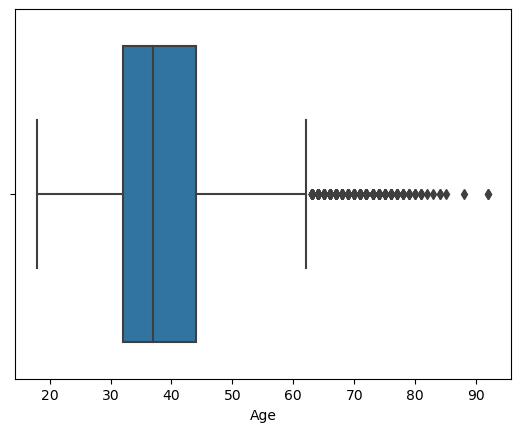

In [19]:
sns.boxplot(x=df['Age'])
plt.show()

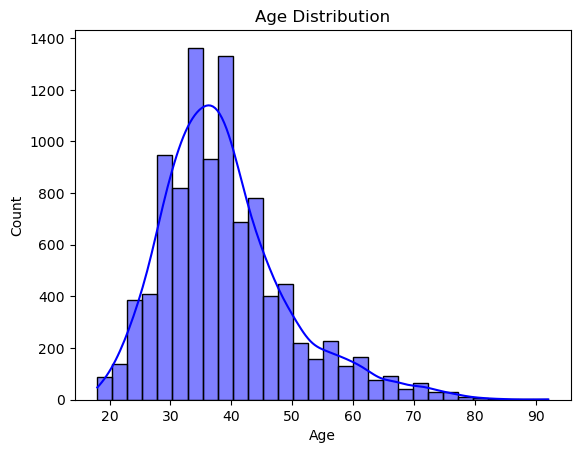

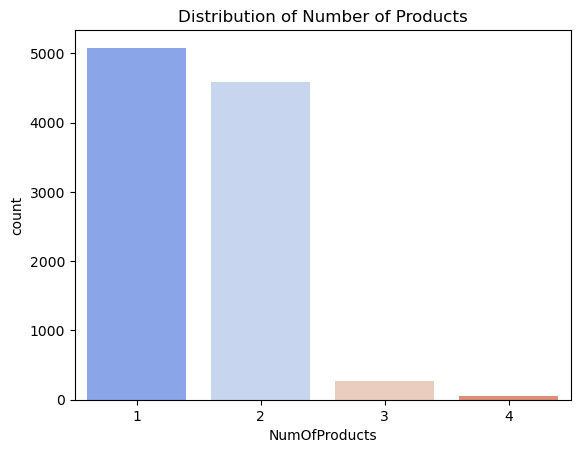

In [20]:
# Distribution of Age
sns.histplot(df['Age'], bins=30, kde=True, color='blue')
plt.title('Age Distribution')
plt.show()

# Distribution of Number of Products
sns.countplot(x='NumOfProducts', data=df, palette='coolwarm')
plt.title('Distribution of Number of Products')
plt.show()

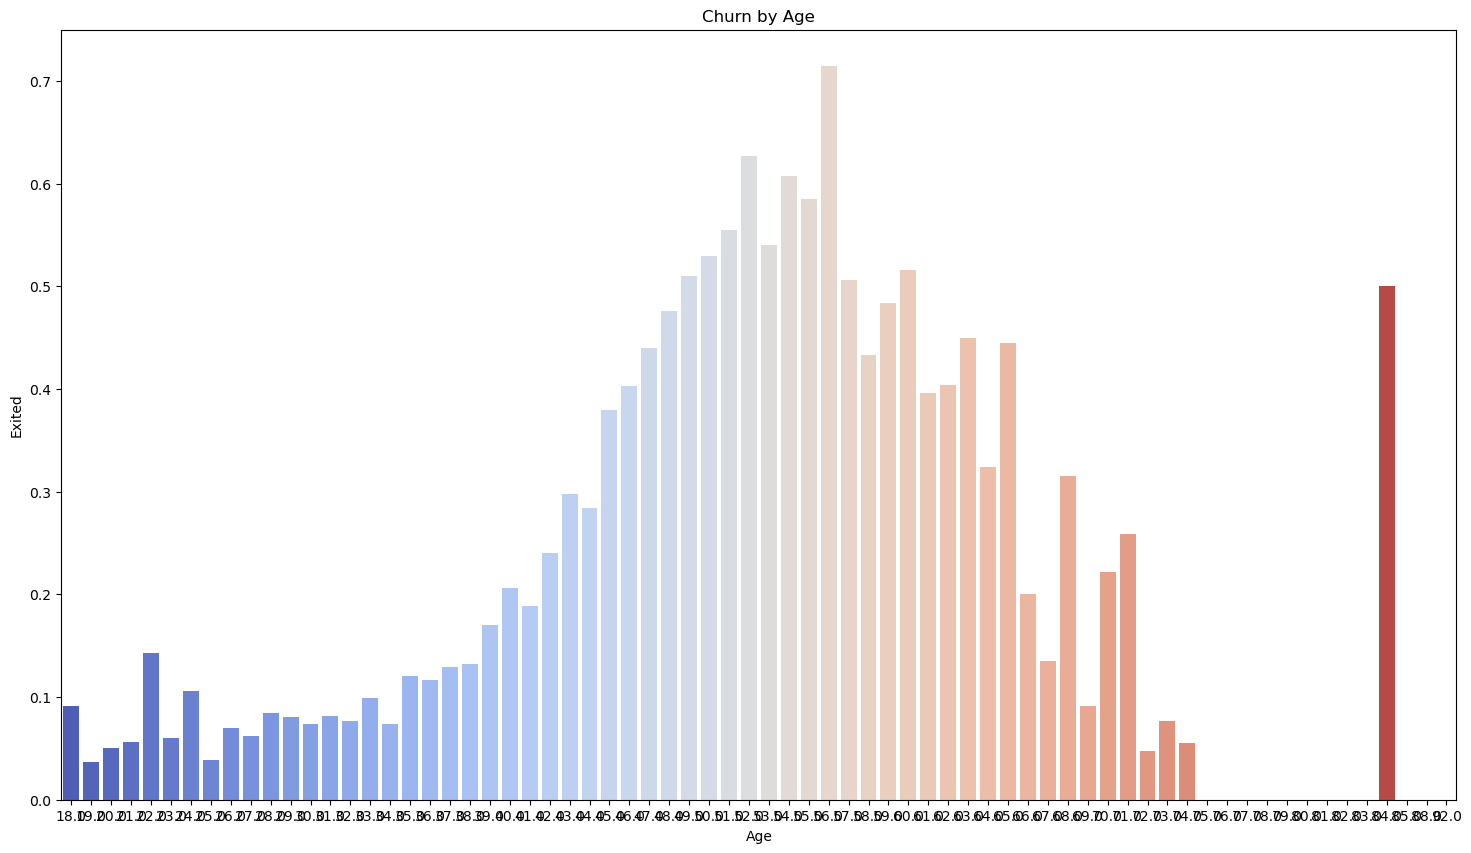

In [21]:
plt.figure(figsize=(18,10))
sns.barplot(x='Age', y='Exited', data=df, ci=None, palette='coolwarm')
plt.title('Churn by Age')
plt.show()

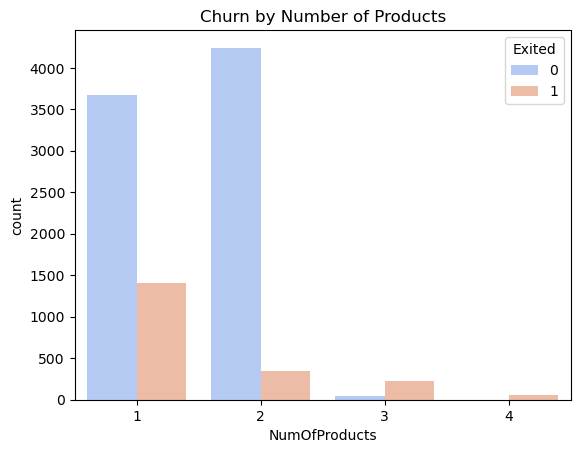

In [22]:
sns.countplot(x='NumOfProducts', hue='Exited', data=df, palette='coolwarm')
plt.title('Churn by Number of Products')
plt.show()

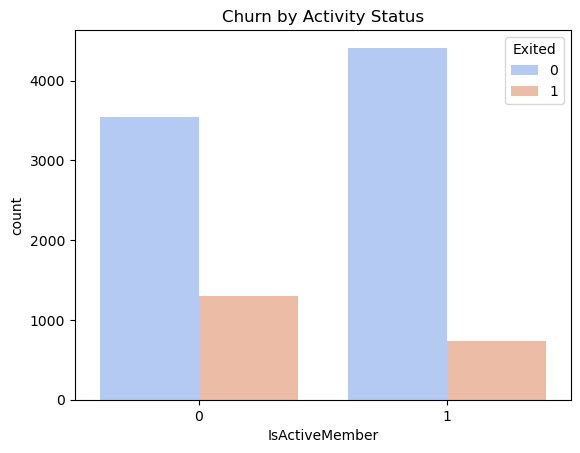

In [23]:
sns.countplot(x='IsActiveMember', hue='Exited', data=df, palette='coolwarm')
plt.title('Churn by Activity Status')
plt.show()

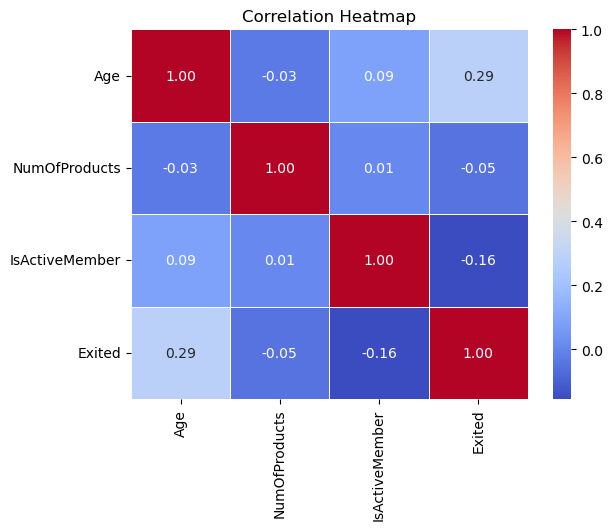

In [24]:
corr_matrix = df[['Age', 'NumOfProducts', 'IsActiveMember', 'Exited']].corr()

# Heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

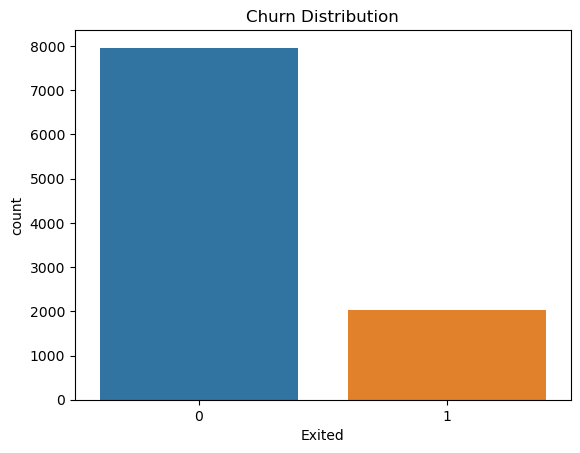

In [25]:
# Churn distribution
sns.countplot(data=df, x='Exited')
plt.title('Churn Distribution')
plt.show()


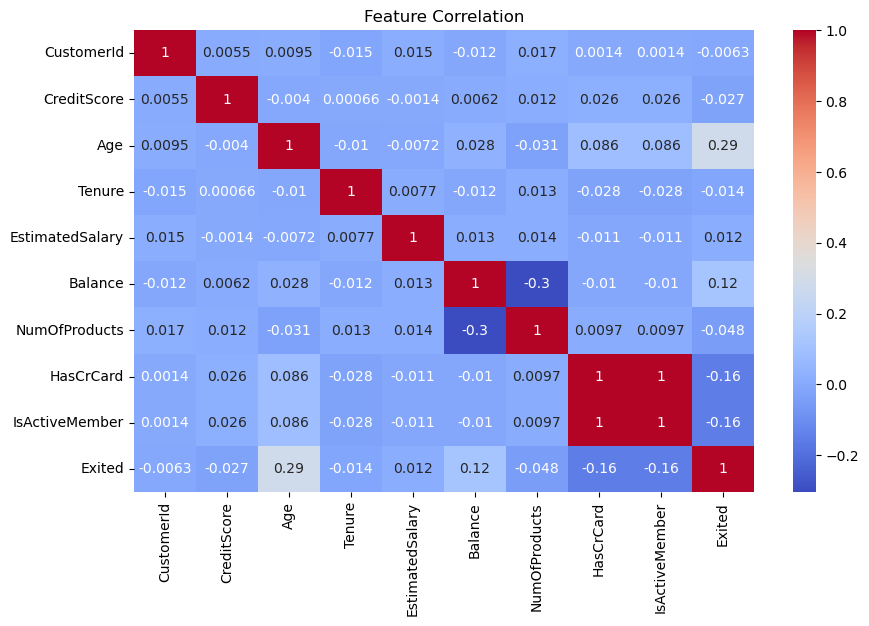

In [26]:
# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Feature Correlation')
plt.show()

## Data Preprocessing

In [27]:
# Encode Gender
df['Gender'] = LabelEncoder().fit_transform(df['Gender'])

# One-hot encode Geography
df = pd.get_dummies(df, columns=['Geography'], drop_first=True)
df

,CustomerId,Surname,CreditScore,Gender,Age,Tenure,EstimatedSalary,Balance,NumOfProducts,HasCrCard,IsActiveMember,Exited,Geography_Germany,Geography_Spain
0,15634602,Hargrave,619,0,42.0,2,101348.88,0.00,1,1,1,1,0,0
2,15647311,Hill,608,0,41.0,1,112542.58,83807.86,1,1,1,0,0,1
3,15619304,Onio,502,0,42.0,8,113931.57,159660.80,3,0,0,1,0,0
4,15701354,Boni,699,0,39.0,1,93826.63,0.00,2,0,0,0,0,0
5,15737888,Mitchell,850,0,43.0,2,79084.10,125510.82,1,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,15606229,Obijiaku,771,1,39.0,5,96270.64,0.00,2,0,0,0,0,0
9997,15569892,Johnstone,516,1,35.0,10,101699.77,57369.61,1,1,1,0,0,0
9998,15584532,Liu,709,0,36.0,7,42085.58,0.00,1,1,1,1,0,0
9999,15682355,Sabbatini,772,1,42.0,3,92888.52,75075.31,2,0,0,1,1,0


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9997 entries, 0 to 10000
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerId         9997 non-null   int64  
 1   Surname            9997 non-null   object 
 2   CreditScore        9997 non-null   int64  
 3   Gender             9997 non-null   int32  
 4   Age                9997 non-null   float64
 5   Tenure             9997 non-null   int64  
 6   EstimatedSalary    9997 non-null   float64
 7   Balance            9997 non-null   float64
 8   NumOfProducts      9997 non-null   int64  
 9   HasCrCard          9997 non-null   int64  
 10  IsActiveMember     9997 non-null   int64  
 11  Exited             9997 non-null   int64  
 12  Geography_Germany  9997 non-null   uint8  
 13  Geography_Spain    9997 non-null   uint8  
dtypes: float64(3), int32(1), int64(7), object(1), uint8(2)
memory usage: 995.8+ KB


## Feature selection

In [29]:
# Feature selection
features = ['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
            'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
            'Geography_Germany', 'Geography_Spain']
X = df[features]
y = df['Exited']
# to check we the class is imbalanced
y.value_counts(normalize=True)

0    0.796239
1    0.203761
Name: Exited, dtype: float64

In [30]:
# Split the raw (unscaled) data first
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
#  Apply SMOTE on training set only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [32]:
# Fit scaler only on training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)

# Transform test data using same scaler
X_test_scaled = scaler.transform(X_test)

## Logistic Regression

In [33]:
log_model = LogisticRegression()
log_model.fit(X_train_scaled, y_train_resampled)

LogisticRegression()

In [34]:
y_pred_log = log_model.predict(X_test_scaled)

In [35]:
print("Logistic Regression Report:")
print(classification_report(y_test, y_pred_log))
print("--------------------------------------------------")
print("ROC AUC Score:", roc_auc_score(y_test, log_model.predict_proba(X_test_scaled)[:, 1]))

Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.88      0.79      0.83      1581
           1       0.42      0.58      0.49       419

    accuracy                           0.75      2000
   macro avg       0.65      0.68      0.66      2000
weighted avg       0.78      0.75      0.76      2000

--------------------------------------------------
ROC AUC Score: 0.7407051819110891


In [36]:
# Define param grid
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # supports both l1 and l2
}

# Grid Search
grid_lr = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy')
grid_lr.fit(X_train_scaled, y_train_resampled)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear']},
             scoring='accuracy')

In [37]:
# Best result
print("Best Params:", grid_lr.best_params_)
print("Best Score:", grid_lr.best_score_)

Best Params: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.7789681408360358


In [38]:
# Predict using best model
best_lr = grid_lr.best_estimator_
y_pred = best_lr.predict(X_test_scaled)

# Evaluation
print(" Test Accuracy:", accuracy_score(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred))
print("\n Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

 Test Accuracy: 0.739

 Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.78      0.83      1581
           1       0.41      0.58      0.48       419

    accuracy                           0.74      2000
   macro avg       0.64      0.68      0.65      2000
weighted avg       0.78      0.74      0.75      2000


 Confusion Matrix:
 [[1236  345]
 [ 177  242]]


## Random Forest

In [39]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train_resampled)


RandomForestClassifier(random_state=42)

In [40]:
y_pred_rf = rf_model.predict(X_test_scaled)

In [41]:
print("Random Forest Report:")
print(classification_report(y_test, y_pred_rf))
print("--------------------------------------------------")
print("ROC AUC Score:", roc_auc_score(y_test, rf_model.predict_proba(X_test_scaled)[:, 1]))

Random Forest Report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.89      1581
           1       0.57      0.59      0.58       419

    accuracy                           0.82      2000
   macro avg       0.73      0.74      0.73      2000
weighted avg       0.82      0.82      0.82      2000

--------------------------------------------------
ROC AUC Score: 0.8347644084964805


In [42]:
# Define parameter grid
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Random Search CV
rf = RandomForestClassifier(random_state=42)
grid_rf = RandomizedSearchCV(rf, rf_param_grid, cv=5, scoring='accuracy', n_iter=10)
grid_rf.fit(X_train_scaled, y_train_resampled)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   param_distributions={'max_depth': [5, 10, 15, None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   scoring='accuracy')

In [43]:
# Results
best_rf = grid_rf.best_estimator_
print("Best RF Params:", grid_rf.best_params_)
print("Best RF CV Accuracy:", grid_rf.best_score_)

# Predict & evaluate
y_pred_rf = best_rf.predict(X_test_scaled)
print("RF Test Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\n RF Classification Report:\n", classification_report(y_test, y_pred_rf))
print("\n RF Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


Best RF Params: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None}
Best RF CV Accuracy: 0.8554688431237857
RF Test Accuracy: 0.819

 RF Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.88      0.88      1581
           1       0.56      0.61      0.58       419

    accuracy                           0.82      2000
   macro avg       0.73      0.74      0.73      2000
weighted avg       0.82      0.82      0.82      2000


 RF Confusion Matrix:
 [[1384  197]
 [ 165  254]]


##  XGBoost Classifier

In [44]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_scaled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [45]:
y_pred_xgb = xgb_model.predict(X_test_scaled)

In [46]:
print("XGBoost Report:")
print(classification_report(y_test, y_pred_xgb))
print("--------------------------------------------------")

print("ROC AUC Score:", roc_auc_score(y_test, xgb_model.predict_proba(X_test_scaled)[:, 1]))

XGBoost Report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      1581
           1       0.58      0.54      0.56       419

    accuracy                           0.82      2000
   macro avg       0.73      0.72      0.72      2000
weighted avg       0.82      0.82      0.82      2000

--------------------------------------------------
ROC AUC Score: 0.8295495887168479


In [47]:
#  Define parameter grid
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
    'reg_alpha': [0, 0.1, 1],     # L1 regularization
    'reg_lambda': [1, 5, 10]      # L2 regularization
}

#  Random Search CV
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
grid_xgb = RandomizedSearchCV(xgb, xgb_param_grid, cv=5, scoring='accuracy', n_iter=10)
grid_xgb.fit(X_train_scaled, y_train_resampled)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_cons...
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None, ...),
                   param_distributions={'colsample_bytree': [0.8, 1],
                                        'learning_rate': [0.01, 0.1, 0.3],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [100, 200],
                                        'reg_alpha': [0, 0.1, 1],
                                        'reg_lambda': [1, 5, 10],
                                        'subsample': [0.8, 1]},
                   scoring='accuracy')

In [48]:
#  Results
best_xgb = grid_xgb.best_estimator_
print(" Best XGB Params:", grid_xgb.best_params_)
print(" Best XGB CV Accuracy:", grid_xgb.best_score_)

#  Predict & evaluate
y_pred_xgb = best_xgb.predict(X_test_scaled)
print(" XGB Test Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\n XGB Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("\n XGB Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))


 Best XGB Params: {'subsample': 0.8, 'reg_lambda': 5, 'reg_alpha': 1, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.3, 'colsample_bytree': 1}
 Best XGB CV Accuracy: 0.8692652951881922
 XGB Test Accuracy: 0.825

 XGB Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.90      0.89      1581
           1       0.59      0.54      0.56       419

    accuracy                           0.82      2000
   macro avg       0.74      0.72      0.73      2000
weighted avg       0.82      0.82      0.82      2000


 XGB Confusion Matrix:
 [[1423  158]
 [ 192  227]]


## 📈 Model Comparison

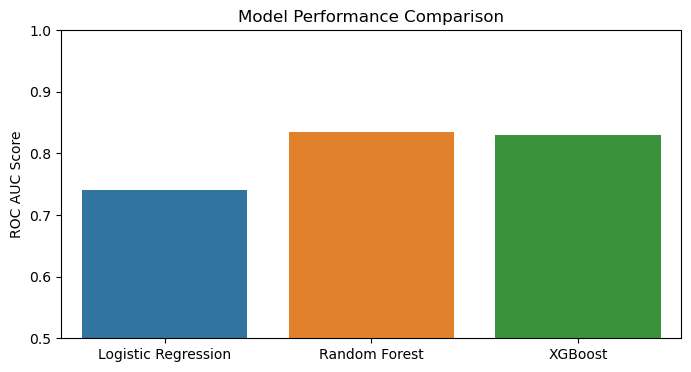

In [49]:
models = ['Logistic Regression', 'Random Forest', 'XGBoost']
roc_scores = [
    roc_auc_score(y_test, log_model.predict_proba(X_test_scaled)[:, 1]),
    roc_auc_score(y_test, rf_model.predict_proba(X_test_scaled)[:, 1]),
    roc_auc_score(y_test, xgb_model.predict_proba(X_test_scaled)[:, 1])
]

plt.figure(figsize=(8, 4))
sns.barplot(x=models, y=roc_scores)
plt.ylabel('ROC AUC Score')
plt.title('Model Performance Comparison')
plt.ylim(0.5, 1)
plt.show()


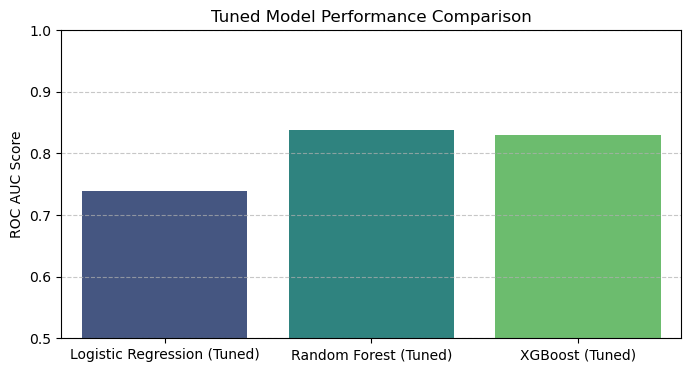

In [50]:
models = ['Logistic Regression (Tuned)', 'Random Forest (Tuned)', 'XGBoost (Tuned)']
roc_scores = [
    roc_auc_score(y_test, best_lr.predict_proba(X_test_scaled)[:, 1]),
    roc_auc_score(y_test, best_rf.predict_proba(X_test_scaled)[:, 1]),
    roc_auc_score(y_test, best_xgb.predict_proba(X_test_scaled)[:, 1])
]

# Plotting
plt.figure(figsize=(8, 4))
sns.barplot(x=models, y=roc_scores, palette="viridis")
plt.ylabel('ROC AUC Score')
plt.title('Tuned Model Performance Comparison')
plt.ylim(0.5, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

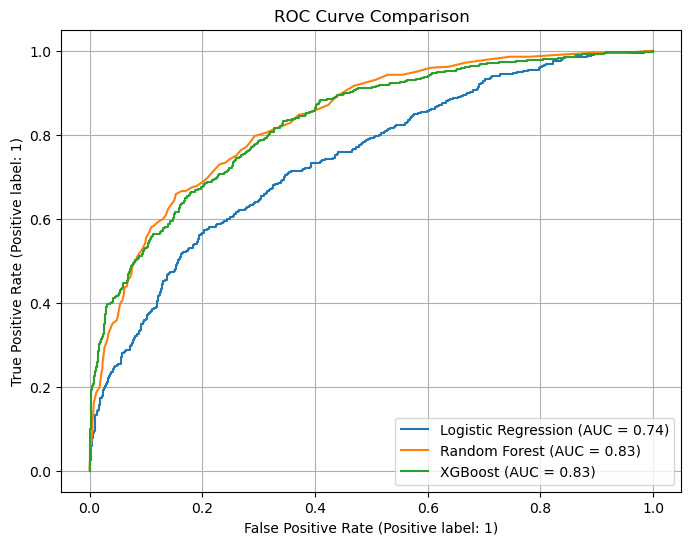

In [51]:
# Set up the plot
plt.figure(figsize=(8, 6))

# Logistic Regression ROC
RocCurveDisplay.from_estimator(log_model, X_test_scaled, y_test, name='Logistic Regression', ax=plt.gca())

# Random Forest ROC
RocCurveDisplay.from_estimator(rf_model, X_test_scaled, y_test, name='Random Forest', ax=plt.gca())

# XGBoost ROC
RocCurveDisplay.from_estimator(xgb_model, X_test_scaled, y_test, name='XGBoost', ax=plt.gca())

# Final plot 
plt.title('ROC Curve Comparison')
plt.grid(True)
plt.show()

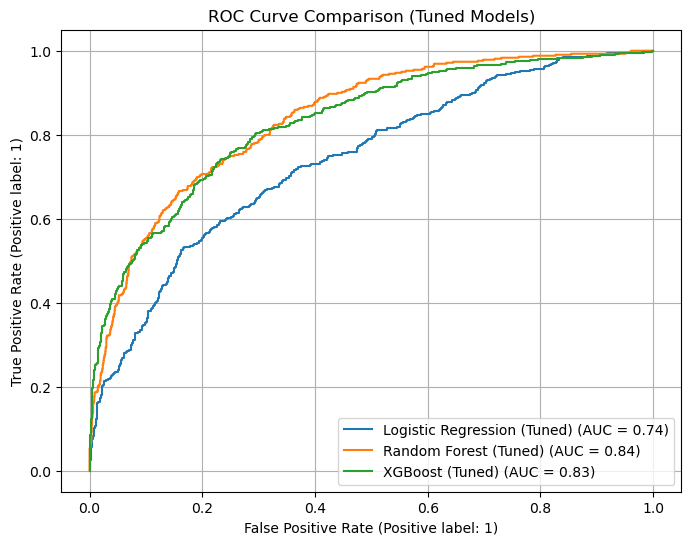

In [52]:

# Set up the plot
plt.figure(figsize=(8, 6))

# Logistic Regression (Tuned)
RocCurveDisplay.from_estimator(best_lr, X_test_scaled, y_test, name='Logistic Regression (Tuned)', ax=plt.gca())

# Random Forest (Tuned)
RocCurveDisplay.from_estimator(best_rf, X_test_scaled, y_test, name='Random Forest (Tuned)', ax=plt.gca())

# XGBoost (Tuned)
RocCurveDisplay.from_estimator(best_xgb, X_test_scaled, y_test, name='XGBoost (Tuned)', ax=plt.gca())

# Final plot
plt.title('ROC Curve Comparison (Tuned Models)')
plt.grid(True)
plt.legend(loc='lower right')
plt.show()

## Save the Best Model

In [53]:
# Save the tuned Random Forest model
joblib.dump(rf_model, 'random_forest_churn_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

print(" Tuned Random Forest model saved as 'random_forest_churn_model.pkl'")

 Tuned Random Forest model saved as 'random_forest_churn_model.pkl'


 After comparing multiple models, Random Forest delivered the best performance, with a ROC AUC of 0.85 F1-score of 0.58%, and superior capability to capture high-risk churn customers. This model enables proactive customer retention strategies.

We’ll judge based on:

Accuracy-->	Overall correctness

Precision-->	How many predicted churns are actual churns

Recall-->	How many actual churns were caught

F1-Score-->	Balance of precision & recall

ROC AUC Score-->	Model’s ability to distinguish churners

In [54]:
sample_customer = pd.DataFrame([{
    'CreditScore': 650,
    'Gender': 1,  # Male
    'Age': 42,
    'Tenure': 3,
    'Balance': 75000.0,
    'NumOfProducts': 2,
    'HasCrCard': 1,
    'IsActiveMember': 1,
    'EstimatedSalary': 50000.0,
    'Geography_Germany': 0,
    'Geography_Spain': 1
}])

In [55]:
sample_customer_scaled = scaler.transform(sample_customer)

In [56]:
# Predict churn probability using Random Forest
churn_prob = rf_model.predict_proba(sample_customer_scaled)[0][1]
print(f"Churn Probability (Random Forest): {churn_prob:.2%}")

Churn Probability (Random Forest): 12.00%


Based on the customer’s profile and behavior, the Random Forest model predicts a 12.00% chance that this customer will leave the bank. Our customer has a churn probability of 12.00, so they fall into the "Low Risk" zone → they're unlikely to churn.

Probability Range	    Churn Risk Level	    Recommended Action

0.00 – 0.30	              Low Risk	              Likely to stay

0.31 – 0.70	              Medium Risk	          Monitor / Engage

0.71 – 1.00	              High Risk	            Likely to churn – take action
